# Importing & analyzing google search history data!


In this notebook you can analyze your google search history data. First, you have to request your data from google, with instructions that you can find [here](https://goo-searches-analyzer.herokuapp.com/). 

The goal is to get your data in a more usable format that what google provides when you're requesting it and be able to do some quantitative analyses yourself. And of course to get some nice plots!

All of the plots that are generated from this notebook will be saved in your Open Humans home folder, so check that out once you're done.



### Step 0: Import your data from Open Humans!
Unless you know what you're doing I'd recommend not changing this part:

In [40]:
import zipfile, requests, os, json, tempfile
from bs4 import BeautifulSoup

response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)
for entry in user['data']:
    if entry['source'] == "direct-sharing-151": # unique project id (you can find that in your OH website)
        google_data_url = entry['download_url']
        break
google_data_url

tf = tempfile.NamedTemporaryFile()
print('downloading file')
tf.write(requests.get(google_data_url).content)# write a temporary file with the download request
tf.flush()
zf = zipfile.ZipFile(tf.name)
print('reading index')
with zf.open('Takeout/My Activity/Search/MyActivity.html', 'r') as f:
    soup = BeautifulSoup(f)

downloading file
reading index


/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/conda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html5lib")

  markup_type=markup_type))


### 1. Retrieve your google searches from the messy .html file that you got from Google
Here we're simply retrieving the search queries that you made to google, and the dates when you made them

In [41]:
divs = soup.find_all('div', class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1")

search_queries = []
dates = []

for element in divs:
    if str(element.contents[0]).startswith('Searched'):
        search_queries.append(element.contents[1].text.split())
        dates.append(element.contents[-1])

### 2. Keep only the essential search terms

Here we'll be removing stop words (common words, such as "the" / "they", etc). The goal is to keep only the most infomrative search terms, in the form of a list ('filtered_words').

In [42]:
import nltk 
nltk.download('stopwords')

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
filtered_words = [[word for word in single_search if word not in stopwords.words('english')] for single_search in search_queries]



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 3. Do some more formatting

Here we are extracting information about the date and time when you did your searches. Also, we're breaking down each search into unique search terms ('single_words')

In [43]:
from datetime import datetime, time

formated_dates = [datetime.strptime(sdate, "%b %d, %Y, %I:%M:%S %p") for sdate in dates]
formated_days = [sdate.isoweekday() for sdate in formated_dates]

single_words = []
single_dates = []
single_days = []
for search,timepoint,day in zip(filtered_words, formated_dates, formated_days):
    for word in search:
        single_words.append(word.replace("\"", "").replace("“", "").replace('\'', '').replace('‘', ''))
        single_dates.append(timepoint)
        single_days.append(day)

### 4. Time to plot something!

Now we're ready to combine everything into a dataframe and do our very first plot! We'll be plotting the frequency of searches for the top 10 most searched terms. You can change that by modifying 'items2plot'

Not very surprisingly, my efforts to learn python clearly show here! Also, it wouldn't be too hard to guess that I'm into neuroscience, programming experiments with [psychopy](http://www.psychopy.org/) and mainly working with electroencephalography data and [mne](https://www.martinos.org/mne/stable/index.html).

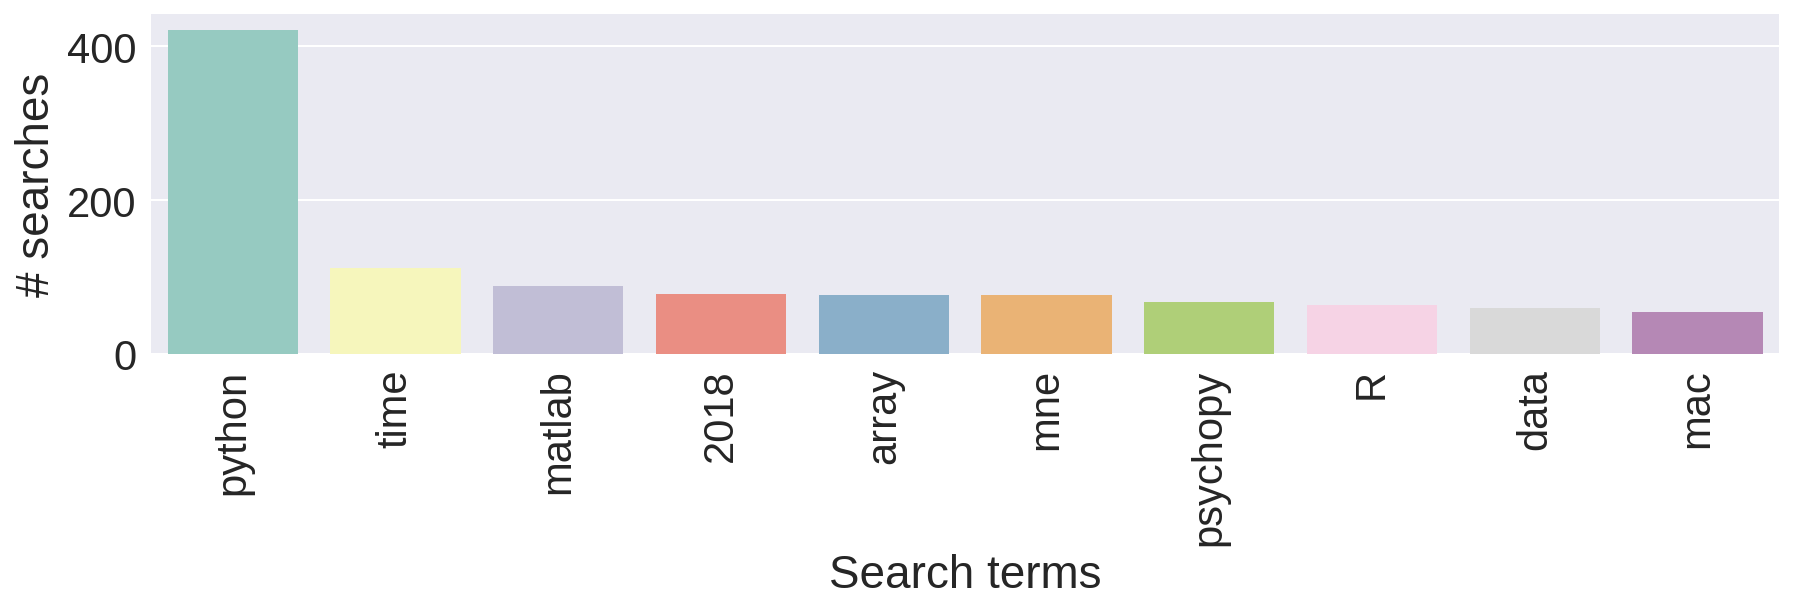

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab, os

# combine everything in a dataframe:
searches_df = pd.DataFrame({'Searches' : single_words,
 'Dates' : single_dates, 'Days': single_days}, columns=['Searches','Dates','Days'])

searches_df_week = searches_df.loc[searches_df['Days'] <= 5]
searches_df_weekend = searches_df.loc[searches_df['Days'] > 5]

items2plot = 10 # number of top terms we want to plot.
cpalette = sns.color_palette("Set3", items2plot)

searches_counted = searches_df.groupby('Searches').count().sort_values(by=['Dates'],ascending=False).reset_index()
dictPalette = {}
for counter,search_term in enumerate(list(searches_counted[:items2plot]['Searches'])):
    dictPalette[search_term] = cpalette[counter]

# and the actual plot:
%matplotlib inline 
fig=plt.figure(figsize=(14, 3), dpi= 150)
sns.set(font_scale = 2)
sns.barplot(y='Dates',
                x='Searches',
                data=searches_counted[:items2plot], palette=cpalette)

plt.xticks(rotation=90)
plt.ylabel('# searches')
plt.xlabel('Search terms')

# save figure:
out_f = os.getcwd()
pylab.savefig(out_f + '/TopSearches.png', bbox_inches='tight')


### 5. How do my searches evolve over the past few months?

Now it's time to use all the date & time information that we've been extracting. We're still keeping the top 10 search terms that we extracted in step 4, but now we're looking how each of them changes over time.

In my case I unfortunately only had google search data from November 2017. My python queries peak in January 2018, and after that they keep a rather low but steady pace. Maybe I did learn something after all!

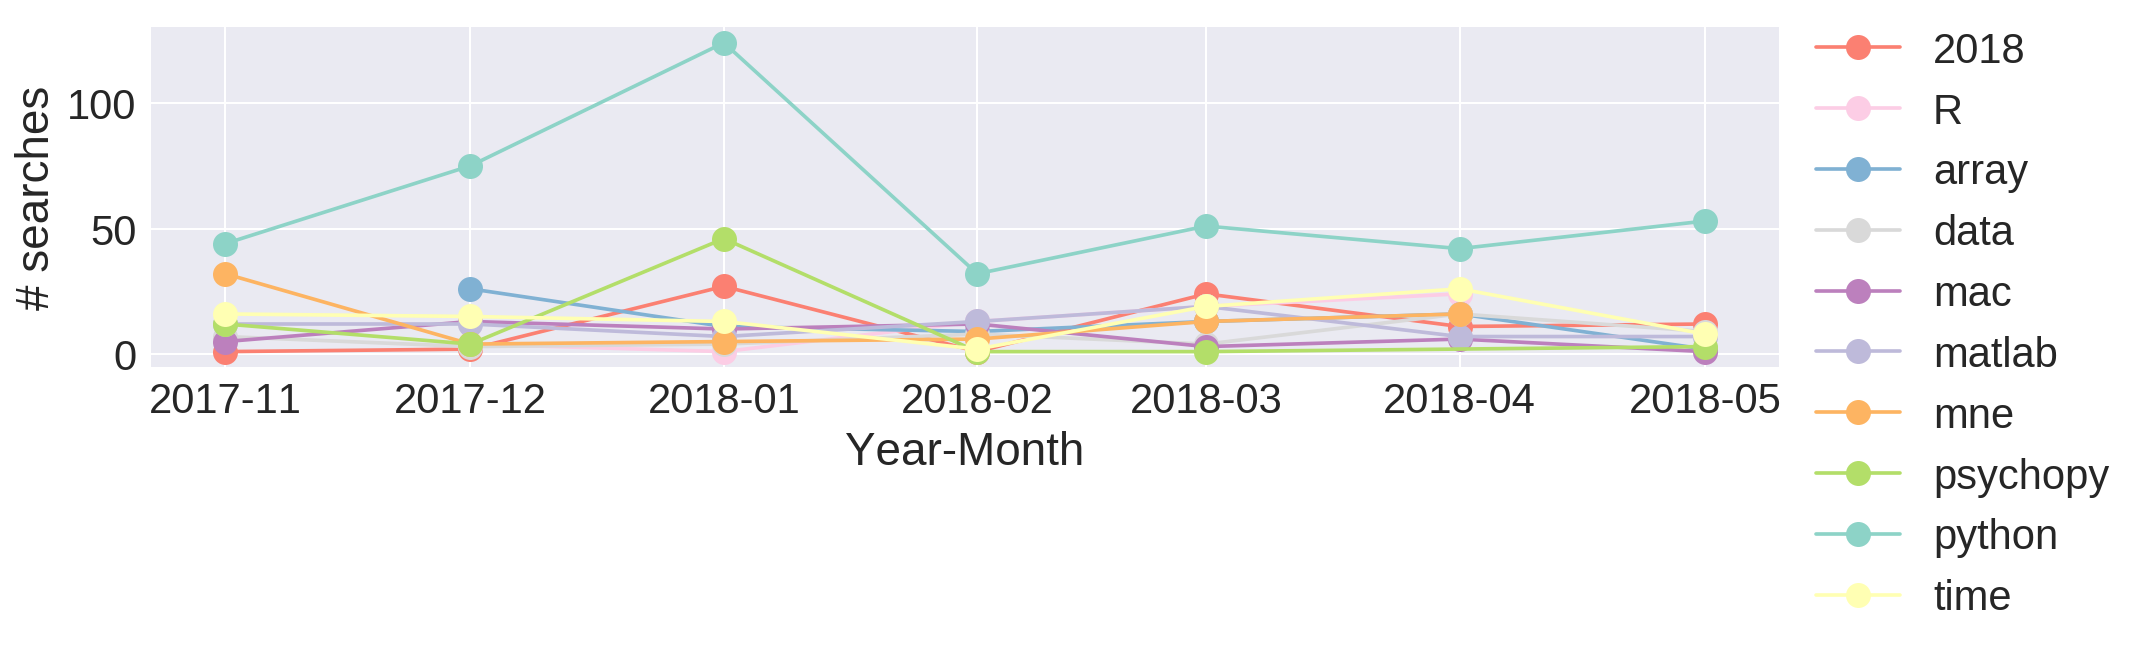

In [54]:
def export_year_month(x):
    return datetime.strptime(datetime.strftime(x, '%Y-%m'),'%Y-%m')

searches_df['year_month'] = searches_df['Dates'].apply(export_year_month)

searches_by_month = searches_df.groupby(['Searches','year_month']).count().reset_index()
top_queries = searches_by_month[searches_by_month['Searches'].isin(list(searches_counted[:items2plot]['Searches']))]

%matplotlib inline 

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14, 3), dpi=150)

counter = 0
for name, group in top_queries[top_queries['year_month']>datetime.strptime('2017-10-01', '%Y-%m-%d')].groupby('Searches'):
    plt.plot(group.year_month, group.Dates, marker = 'o', ms=12, label = name, color = dictPalette[name])
    counter +=1
    
plt.xlabel('Year-Month')
plt.ylabel('# searches')
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.1),
         ncol=1, fancybox=True, shadow=True)

pylab.savefig(out_f + '/TopSearches_By_Month.png')


### 6. How do my searches change throughout the day?

Going back to the time information that we extracted, you can now group the top search terms by the hour of the day when you searched for them.

I'd say that I'm an python evening kind of person...

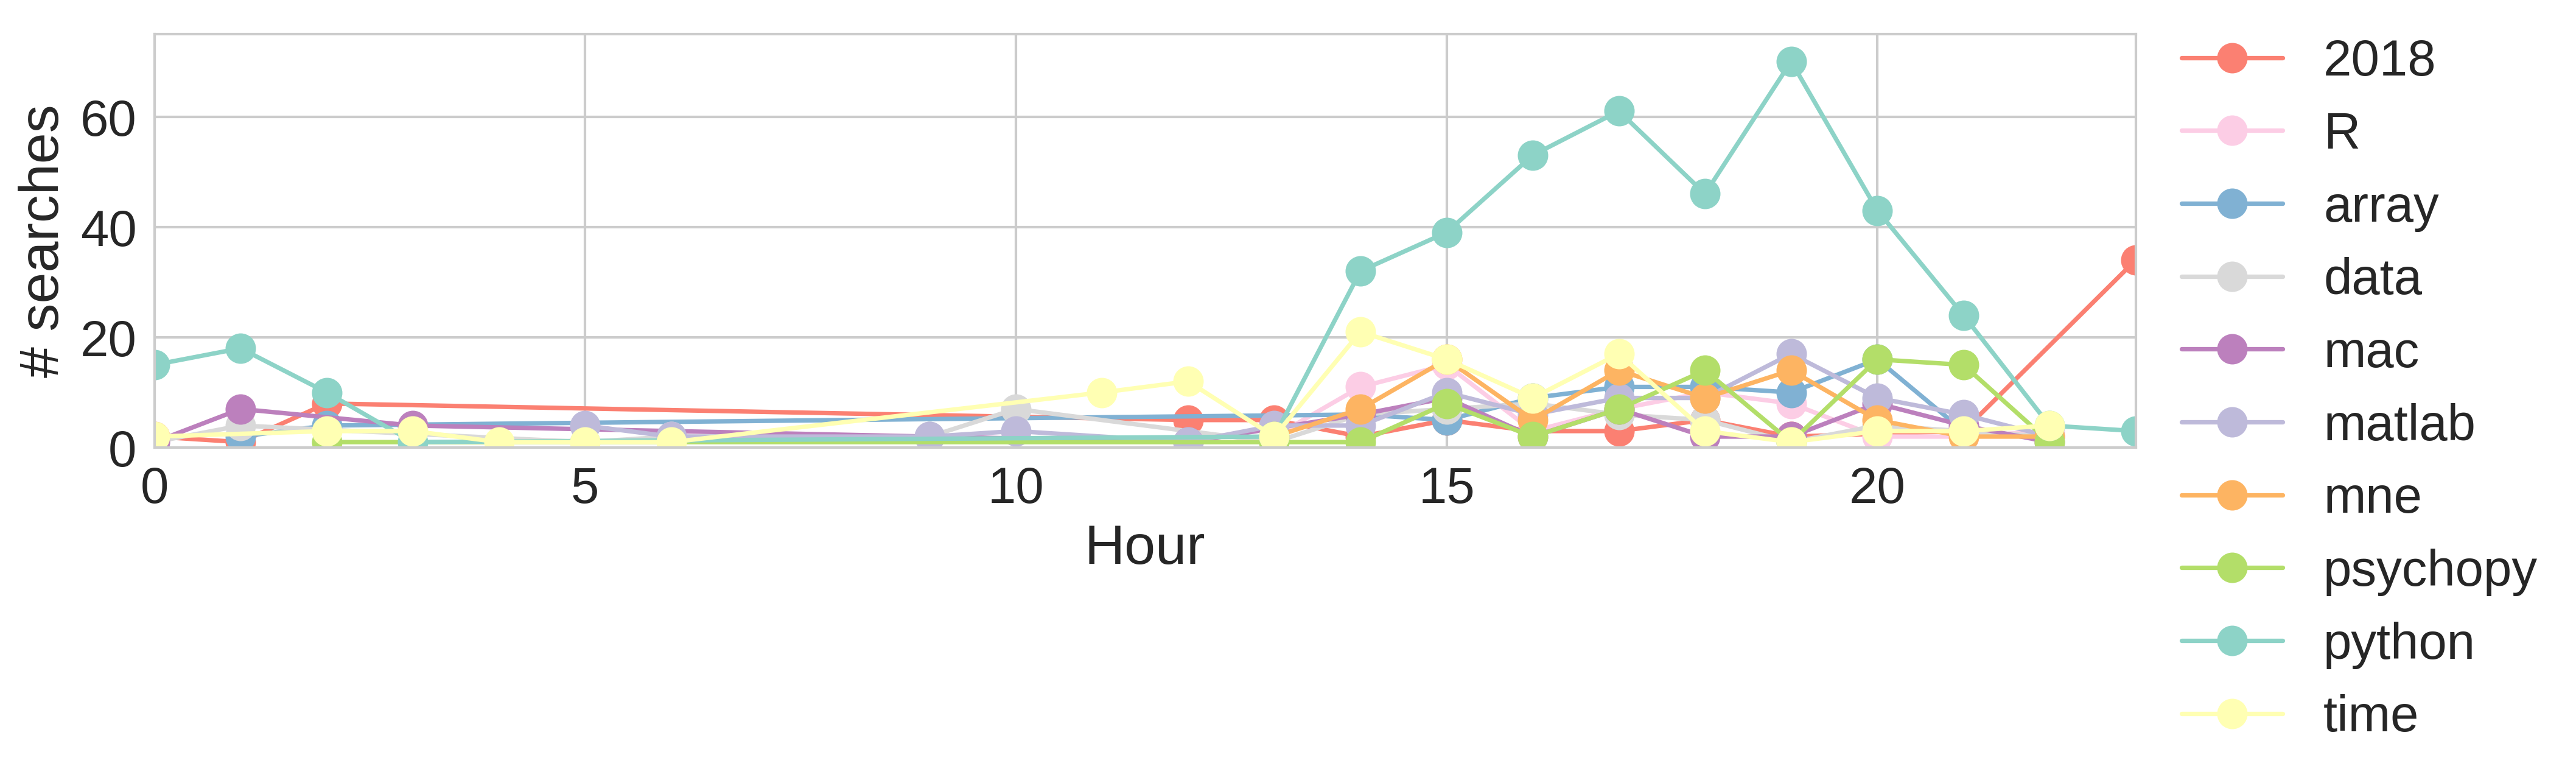

In [48]:
def export_hour(x):
    return int(datetime.strftime(x, '%H'))

searches_df['Hour'] = searches_df['Dates'].apply(export_hour)

searches_by_hour = searches_df.groupby(['Searches','Hour']).count().reset_index()
top_queries_hour = searches_by_hour[searches_by_hour['Searches'].isin(list(searches_counted[:items2plot]['Searches']))]

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14, 3), dpi = 300)
counter = 0
for name, group in top_queries_hour.groupby('Searches'):
    plt.plot(group.Hour, group.Dates, marker = 'o', ms=12, label = name, color = dictPalette[name])
    counter +=1
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.1),
          ncol=1, fancybox=True, shadow=True)
plt.ylim(0,75)
plt.xlim(0,23)

plt.xlabel('Hour')
plt.ylabel('# searches')

pylab.savefig(out_f + '/TopSearches_ByHour.png', bbox_inches='tight')

### 7. Zooming into specific search terms

Here you can choose specific terms from your searches and see how these evolve over time of the day. You can add your own search terms in the first line of this cell ('my_favourite_searches'). For this we normalize each time course by the total number of searches for a specific term.

In my case, after figuring out that I'm doing most of my python searches in the evening, I wanted to see whether my R or matlab schedules are any different. It looks like I'm mostly searching for help with R earlier in the day compared to python or matlab...

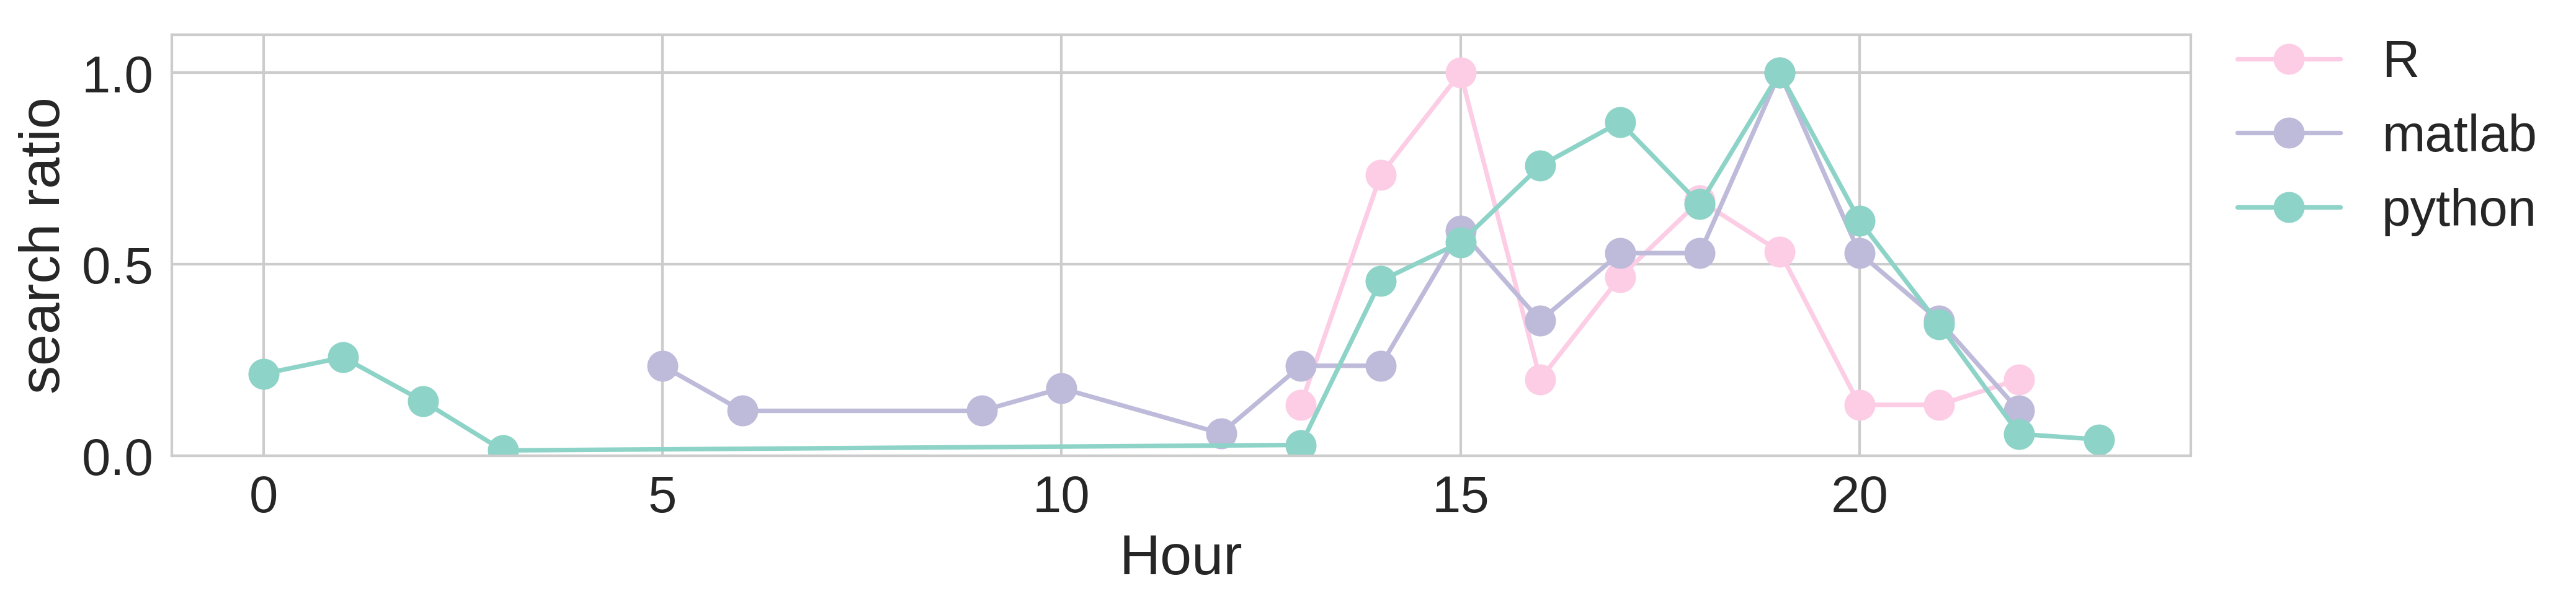

In [50]:
# focus on these search terms only:
my_favourite_searches = ['python', 'matlab','R']

searches_by_programming = searches_df.groupby(['Searches','Hour']).count().reset_index()
top_queries_programming = searches_by_hour[searches_by_programming['Searches'].isin(my_favourite_searches)]

%matplotlib inline 

plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(14, 3), dpi = 300)
counter = 0
for name, group in top_queries_programming.groupby('Searches'):
    plt.plot(group.Hour, group.Dates/pd.Series.max(group.Dates), marker = 'o', ms=12, label = name, color = dictPalette[name])
    counter +=1
    
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.1),
          ncol=1, fancybox=True, shadow=True)
plt.ylim(0,1.1)

plt.xlabel('Hour')
plt.ylabel('search ratio')

pylab.savefig(out_f + '/TopSearches_ByProgramming.png', bbox_inches='tight')

### 8. Google searches as a network

Now you can visualize your searches within a network. Here you can see whether some of your search terms tend to co-occur with others, and in which frequency. The first step for this analysis is to create a graph object containing all search terms.

In [73]:
import networkx as nx
import itertools

G = nx.MultiGraph()
L=2

# for each unique search term add a node:
G.add_nodes_from(list(searches_counted['Searches']))

# Prepare queries by stripping them from unwanted characters:
filtered_words_stripped = []
for search in filtered_words:
    filtered_words_stripped.append([word.replace("\"", "").replace("“", "").replace('\'', '').replace('‘', '') for word in search])

# for each stripped query add an edge:
for queries in filtered_words_stripped:
    for subset in itertools.combinations(queries, L):
        G.add_edges_from([subset])
        
# Transofrm to a simple graph, and compute the rate of occurence as weights:
Gf = nx.Graph()
for u,v,data in G.edges(data=True):
    w = 1.0
    if Gf.has_edge(u,v):
        Gf[u][v]['weight'] += w
    else:
        Gf.add_edge(u, v, weight=w)
        


### 9. How are my search terms connected?

Time to visualize the connections among the top search terms! For display we're only keeping searches that appear more than 40 times, and are connected with at least 5 other search terms.

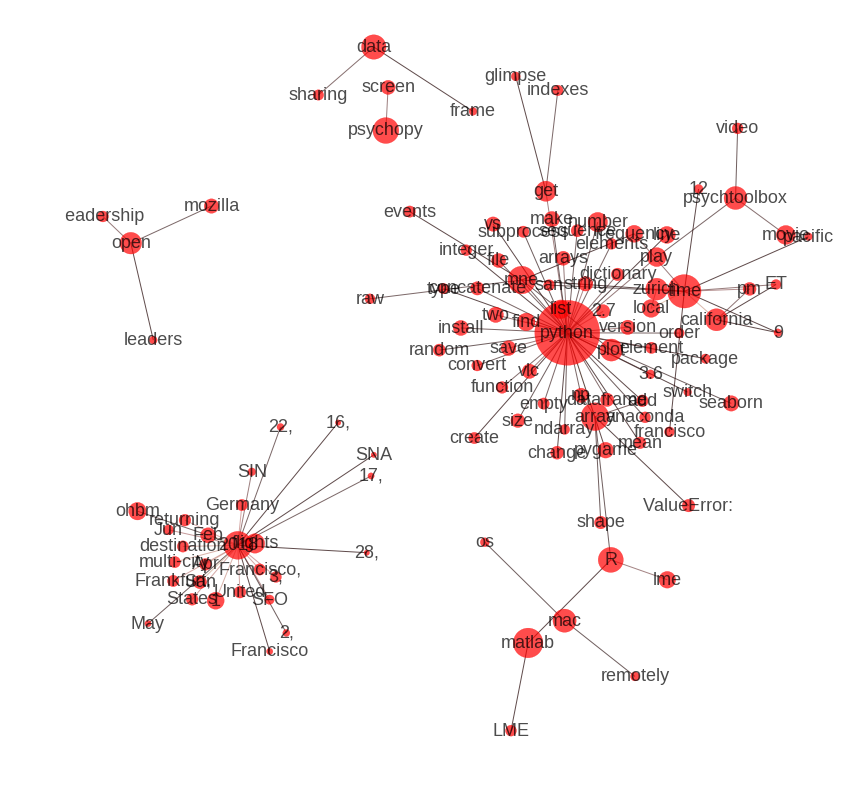

In [74]:
cutoff = 40 # minimum number of times a search term has to appear
cutoff_edge = 5 # minimum number of connections

top_terms = list(searches_counted[searches_counted['Dates']>cutoff]['Searches'])

# filter edges by top occurences & top weights:
top = [edge for edge in Gf.edges(data=True) if (((edge[0] in top_terms) or (edge[1] in top_terms)) and edge[2]['weight'] > cutoff_edge)]

Gf_plot = nx.Graph(top)

# compute size of nodes, proportional to word occurence:
nodesize = [int(searches_counted[searches_counted['Searches'] == node]['Dates'])*10 for node in Gf_plot.nodes]

fsize = 18 # font size
edges,weights = zip(*nx.get_edge_attributes(Gf_plot,'weight').items())
weights=np.array(list(weights))*100 # edge weights (for color)
fig, ax = plt.subplots(figsize=(14, 14))

nx.draw_networkx(Gf_plot, nx.spring_layout(Gf_plot, 0.5), with_labels=True, edge_color=weights, edge_cmap = plt.get_cmap('pink'),font_size = fsize,node_size = nodesize, alpha = 0.7) # OR: nx.draw(G, pos)
plt.axis('off')
pylab.savefig(out_f + '/Network.png', bbox_inches='tight')

### 10. How is my top search term connected to other searches?

Finally, you can see how some of your most searched terms are connected to other searches. For this we're filtering our graph object for a very high cutoff (i.e. rate of search term occurence) and a rather low number of co-occuring connections (cutoff_edge). 

For my queries, it shows the terms that I've been searching together with Python!

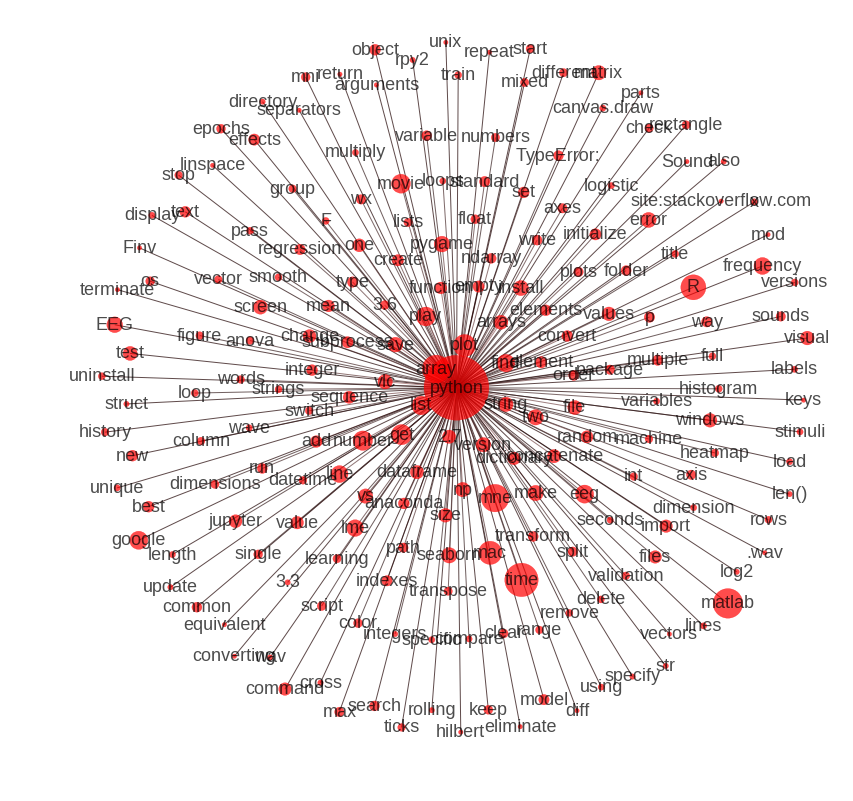

In [75]:
cutoff = 400
cutoff_edge = 1

top_terms = list(searches_counted[searches_counted['Dates']>cutoff]['Searches'])

# filter edges by top occurences & top weights:
top = [edge for edge in Gf.edges(data=True) if (((edge[0] in top_terms) or (edge[1] in top_terms)) and edge[2]['weight'] > cutoff_edge)]

Gf_plot = nx.Graph(top)

# compute size of nodes, proportional to word occurence:
nodesize = [int(searches_counted[searches_counted['Searches'] == node]['Dates'])*10 for node in Gf_plot.nodes]
fsize = 18 # font size
edges,weights = zip(*nx.get_edge_attributes(Gf_plot,'weight').items())
weights=np.array(list(weights))*100 # edge weights (for color)
fig, ax = plt.subplots(figsize=(14, 14))

nx.draw_networkx(Gf_plot, nx.spring_layout(Gf_plot, 0.5), with_labels=True, edge_color=weights, edge_cmap = plt.get_cmap('pink'),font_size = fsize,node_size = nodesize, alpha = 0.7) # OR: nx.draw(G, pos)
plt.axis('off')
pylab.savefig(out_f + '/Network_OneNode.png', bbox_inches='tight')